# BERT - Name Entity Recognition (NER)

Data<a href="https://www.kaggle.com/datasets/debasisdotcom/name-entity-recognition-ner-dataset?select=NER+dataset.csv">
KAGGLE Name Entity Recognition (NER) Dataset</a>

<font color=brown><b>Author:</b><br>
Akash Kumar Gautam<br>
IIT Delhi, Mathematics&Computing<br>
9+ years of Experience in Data Science + Machine Learning + Artifical Intelligence</font>

# Introduction
<p><b>What is NER?</b><br>
    NER, or Named Entity Recognition, is a component of Natural Language Processing (NLP) that focuses on identifying and categorizing named entities within a given text.
</p>
<p><b>What it does?</b><br>
NER locates and classifies named entities in text, such as people, places, organizations, time expressions, and quantities.
</p>
<p>
    <b>How it works?</b><br>
    Named Entity Recognition (NER) detects specific words or phrases within a document and subsequently categorizes them into established classifications.
</p>
<p>
    <b>Why it's useful?</b><br>
    Named Entity Recognition (NER) enhances document translation by offering contextual insights that aid in comprehending sentences. For instance, in the sentence "Apple released a new iPhone today," NER can recognize "Apple" as an organization.
</p>

<p><b>Notebook Strategy</b><br>
    In this notebook, we will utilize <font style='color:brown'><b>BertForTokenClassification</b></font>, a model provided by the <font color=blue>Transformers </font>library from HuggingFace.
    This model
    is built on the <font color=blue>BERT architecture</font> and features a token <font color=blue>classification head</font>, enabling it to perform predictions at the <font color=blue>token level</font>
    instead of the sequence level. Named entity recognition is generally approached as a token classification task, which is the purpose of
    our implementation
</p>
<p>This notebook explores the concept of <font color=blue><b>transfer learning</b></font>, which involves initially pretraining a large neural network in an unsupervised manner, followed by <font color=blue>fine-tuning</blue></font> the network for a specific task. In this instance, BERT serves as the pretrained neural network, having been trained on two tasks: masked language modeling and next sentence prediction.</p>
<p><b>Fine-tuning</b> involves supervised learning, which indicates that a <b>labeled dataset</b> is required.</p>
<p>
    <b>Note:</b>
    <br>
    <ol>
        <li>
            This notebook presupposes that the reader possesses a fundamental understanding of several key concepts and technologies that are essential for effectively engaging with the content presented herein. Specifically, it assumes familiarity with deep learning, which is a subset of machine learning that focuses on algorithms inspired by the structure and function of the brain, particularly artificial neural networks.
        </li>
        <li>
        Additionally, the reader should have a working knowledge of BERT (Bidirectional Encoder Representations from Transformers), a state-of-the-art natural language processing model developed by Google. BERT is designed to understand the context of words in a sentence by considering the words that come before and after them, making it particularly effective for tasks such as text classification, question answering, and language inference.
    </li>
        <li>
            Furthermore, proficiency in the PyTorch framework is also assumed. PyTorch is an open-source machine learning library widely used for applications in deep learning and artificial intelligence. It provides a flexible and dynamic computational graph, which allows for easy experimentation and debugging, making it a popular choice among researchers and practitioners in the field.
        </li>
    </ol>
    In summary, this notebook is intended for individuals who are already well-versed in these foundational topics, as it will build upon this knowledge to explore more advanced concepts and applications related to deep learning, BERT, and the use of PyTorch for implementing various models and techniques.
</p>

<p>
    <b>Notebook Sections</b><br>
    This notebook is divided into following sections:
    <ul>
        <li>A. Setting Environment</li>
        <li>B. Set the Device (cpu or mps)</li>
        <li>C. Reading Dataset</li>
        <li>D. Pre-Processing</li>
        <li>E. Explore Distribution of Labels</li>
        <li>F. Stratified Splitting</li>
        <li>G. Explore Distribution of Labels - Training, Validation and Testing Dataset</li>
        <li>H. Modelling (includes training Loop)</li>
        <li>I. Evaluation</li>
        <li>J. Testing</li>
        <li>K. Helper Function to make clean Predictions</li>
        <li>L. Inference</li>
        <li>I. Saving and Loading Utilities for Model</li>   
    </ul>
</p>

## A. Setting up the environment and importing Python libraries
<p>
    This notebook assumes that you have the following libraries installed:
    <ul>
        <li>pandas</li>
        <li>numpy</li>
        <li>sklearn</li>
        <li>pytorch</li>
        <li>transformers</li>
        <li>matplotlib</li>
        <li>seaborn</li>
    </ul>
    
</p>

In [153]:
# Uncomment to install libraries
# !pip install pandas
# !pip install numpy
# !pip install scikit-learn
# !pip install torch
# !pip install transformers
# !pip install matplotlib
# !pip install seaborn
# !pip install scikit-multilearn

# Note: For zsh shell remove exclamation (!) mark

In [278]:
import collections
from itertools import chain
import random
import copy
import itertools

import pandas as pd
import numpy as np


from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer
from skmultilearn.model_selection import iterative_train_test_split

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset, random_split
from torch.optim import AdamW

from transformers import BertTokenizer
from transformers import BertForTokenClassification
from transformers import get_linear_schedule_with_warmup

import matplotlib.pyplot as plt
import seaborn as sns

# set the option to display all columns
pd.set_option('display.max_columns', None)

## B. Set Device - Check if MPS (Metal Performance Shaders) is available
<p>
    PyTorch uses the new Metal Performance Shaders (MPS) backend for GPU training acceleration. This MPS backend extends the PyTorch
    framework, providing scripts and capabilities to set up and run operations on Mac.
</p>

In [171]:
def get_device(force_cpu_device=False):
    # default device
    device = torch.device('cpu')
    # Check that MPS  is available
    if not torch.backends.mps.is_available():
        if not torch.backends.mps.is_built():
            print("MPS not available because the current PyTorch install was not "
                  "built with MPS enabled.")
        else:
            print("MPS not available because the current MacOS version is not 12.3+ "
                  "and/or you do not have an MPS-enabled device on this machine.")

    else:
        mps_device = torch.device("mps")
        device = mps_device
        print("mps device found")
    # Force to use the cpu device
    if force_cpu_device:
        print("force to use cpu")
        device = torch.device('cpu')
    return device

##### Check the set device

In [172]:
# get the device
device = get_device()

# device info
print(f"device to be used: {device}")

mps device found
device to be used: mps


## C. Reading Dataset
<p>
    Load the <b>NER dataset</b> provided from the specified path into a <b>pandas dataframe.</b>
</p>

In [173]:
# Note: You can download the data from the Kaggle from the link below:
# https://www.kaggle.com/datasets/debasisdotcom/name-entity-recognition-ner-dataset?select=NER+dataset.csv

# set the filepath for KAGGLE NER Dataset
file_path = "/Users/akg/jupyter/kaggle/project_ner/data/KAGGLE_NER_dataset.csv"

# read the raw NER data
data = pd.read_csv(file_path, encoding='unicode_escape')

##### Peek into raw data

In [174]:
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


## D. Preprocessing Data

### 1. Replacing the NaN values by 'Sentence #'
<p>
    The <b>sentence number</b> column denoted as <b>'Sentence #'</b> has finite values only at the begining of the sentence and rest values are <b>NaN.</b>
    We will assign the sentence number to every word by forward fill method.
</p>

In [175]:
# use the forward fill method
data.loc[:,'Sentence #'] = data.loc[:,'Sentence #'].ffill()

##### peek into dataframe

In [176]:
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


#### 1.1 Check the shape

In [177]:
print(f"Num of rows: {data.shape[0]}")
print(f"Num of cols: {data.shape[1]}")

Num of rows: 1048575
Num of cols: 4


### 2. Drop the unwanted 'POS' column

In [178]:
data.drop(columns=['POS'], inplace=True)

print(f"Updated Cols of data: {data.columns.tolist()}")

Updated Cols of data: ['Sentence #', 'Word', 'Tag']


### 3. Remove all rows that contain NaN 

In [179]:
# drop the null entries
data.dropna(inplace=True)

# display the num of rows
print(f"Updated number of rows: {data.shape[0]}")

Updated number of rows: 1048565


### 4. Verify if there are any NaN values in Word and Tag Columns

#### 4.1 Tag columns

In [180]:
tag_null_mask = data[['Tag']].isnull().any(axis=1)
tag_null_rows = data[tag_null_mask]
print(f"number of rows where tag is NaN: {tag_null_rows.size}")

number of rows where tag is NaN: 0


#### 4.2 Word columns

In [181]:
word_null_mask = data[['Word']].isnull().any(axis=1)
word_null_rows = data[word_null_mask]
print(f"number of rows where word is NaN: {word_null_rows.size}")

number of rows where word is NaN: 0


### 5. Checking Improper Words

#### 5.1 Helper Function
<p>Functions to check if there are any escaped unicode characters</p>

In [182]:
# is ascii
def is_ascii(s):
    return all(ord(c) < 128 for c in s)

# is escaped unicode
def is_escaped_unicode(_str):
    if is_ascii(_str): # escaped unicode is ascii
        return True
    return False

# finally a function to check if word is proper or not
def is_proper_word(_word):
    if not is_escaped_unicode(_word):
        if isinstance(_word, str) and len(_word) < 3:
            return False
    return True

#### 5.2 Create a bool column - 'is_proper_word'

In [183]:
data['is_proper_word'] = data['Word'].apply(is_proper_word)

#### 5.3 Check the data which has improper words

In [184]:
display(data[~data['is_proper_word']])

print(f"The total number of improper words are: {data[~data['is_proper_word']].shape[0]}")

,Sentence #,Word,Tag,is_proper_word
1786,Sentence: 77,,O,False
56462,Sentence: 2556,°C,O,False
124883,Sentence: 5700,s,O,False
124903,Sentence: 5700,s,O,False
181958,Sentence: 8332,,I-tim,False
199965,Sentence: 9159,,O,False
199968,Sentence: 9159,,O,False
219475,Sentence: 10052,,O,False
219476,Sentence: 10052,,O,False
219486,Sentence: 10052,,O,False


The total number of improper words are: 31


####  5.4 Retain the data which has only proper words

In [185]:
data = data[data['is_proper_word']]

#### 5.5 Drop the newly created column 'is_proper_word'

In [186]:
# drop the col 'is_proper_word'
data.drop(columns=['is_proper_word'], inplace=True)

print(f"Updated cols of the data: {data.columns.tolist()}")
print(f"Updated number of rows: {data.shape[0]}")

Updated cols of the data: ['Sentence #', 'Word', 'Tag']
Updated number of rows: 1048534


### 6. Frequency of each tag
<p>Compute the <b>frequeny</b> of each tag</p>

In [187]:
print("Number of tags: {}".format(len(data.Tag.unique())))
frequencies = data.Tag.value_counts()
frequencies

Number of tags: 17


Tag
O        887870
B-geo     37644
B-tim     20333
B-org     20143
I-per     17251
B-per     16990
I-org     16782
B-gpe     15870
I-geo      7414
I-tim      6527
B-art       402
B-eve       308
I-art       297
I-eve       253
B-nat       201
I-gpe       198
I-nat        51
Name: count, dtype: int64

### 7. Count the frequencies of sub-tags in decreasing order
<p>We have sub-tags like <b>geo, org, eve, per</b> e.t.c. Lets compute the frequency of each tag sub-tag in decreasing order.</p>

In [188]:
# Dict for storing the tags and their frequency
tags = {}

# iterate through each tag
for tag, count in zip(frequencies.index, frequencies):
    # Check if the tag is not 'O'
    if tag != "O":
        # extract the sub-tag 
        if tag[2:5] not in tags.keys():
            # create a key with its count
            tags[tag[2:5]] = count
        else:
            # if sub-tag already exists, then simply update the count
            tags[tag[2:5]] += count

# print the sub-tags in sorted order
print(sorted(tags.items(), key=lambda x: x[1], reverse=True))

[('geo', 45058), ('org', 36925), ('per', 34241), ('tim', 26860), ('gpe', 16068), ('art', 699), ('eve', 561), ('nat', 252)]


### 8. Dealing with Tags that could potentially act as Noise
<p> From previous section, we can see that sub-tags - <b>art, eve and nat</b> are relatively very low in number.<br>
    Hence, Tags - <b>"B-art", "I-art", "B-eve", "I-eve", "B-nat", "I-nat" </b> could potentially act as noise.
    Also note that Tag <b>I-gpe</b> is also relatively very low in count and hence it could also act as noise.
    Therefore we will <b>replace</b> all such Tags that have the potential to act as noise.
</p>

In [189]:
# Remove tags having such sub-tags plus an additional I-gpe tag
labels_to_remove = ["B-art", "I-art", "B-eve", "I-eve", "B-nat", "I-nat"] + ['I-gpe']

#### 8.1. Convert such subtags to "O" which is most frequent

In [190]:
data.loc[data['Tag'].isin(labels_to_remove), 'Tag'] = "O"

#### 8.2 Compute updated frequency of each tags

In [191]:
unique_tags = data.Tag.value_counts()
unique_tags

Tag
O        889580
B-geo     37644
B-tim     20333
B-org     20143
I-per     17251
B-per     16990
I-org     16782
B-gpe     15870
I-geo      7414
I-tim      6527
Name: count, dtype: int64

### 9. Compute label Maps
<p>Create two maps:
    <ol>
        <li><b>label2id</b> - maps string labels to its integer index</li>
        <li><b>id2label</b> - maps integer index of labels to strings</li>
    </ol>
</p>

In [192]:
label2id = {k: v for v, k in enumerate(data.Tag.unique())}
id2label = {v: k for v, k in enumerate(data.Tag.unique())}
label2id

{'O': 0,
 'B-geo': 1,
 'B-gpe': 2,
 'B-per': 3,
 'I-geo': 4,
 'B-org': 5,
 'I-org': 6,
 'B-tim': 7,
 'I-per': 8,
 'I-tim': 9}

### 10. Create complete sentences with their labels as one string 

In [193]:
# let's create a new column called "sentence" which groups the words by sentence 
data['sentence'] = data[['Sentence #','Word','Tag']].groupby(['Sentence #'])['Word'].transform(lambda x: ' '.join(x))
# let's also create a new column called "word_labels" which groups the tags by sentence 
data['labels'] = data[['Sentence #','Word','Tag']].groupby(['Sentence #'])['Tag'].transform(lambda x: ','.join(x))
data.head()

,Sentence #,Word,Tag,sentence,labels
0,Sentence: 1,Thousands,O,Thousands of demonstrators have marched throug...,"O,O,O,O,O,O,B-geo,O,O,O,O,O,B-geo,O,O,O,O,O,B-..."
1,Sentence: 1,of,O,Thousands of demonstrators have marched throug...,"O,O,O,O,O,O,B-geo,O,O,O,O,O,B-geo,O,O,O,O,O,B-..."
2,Sentence: 1,demonstrators,O,Thousands of demonstrators have marched throug...,"O,O,O,O,O,O,B-geo,O,O,O,O,O,B-geo,O,O,O,O,O,B-..."
3,Sentence: 1,have,O,Thousands of demonstrators have marched throug...,"O,O,O,O,O,O,B-geo,O,O,O,O,O,B-geo,O,O,O,O,O,B-..."
4,Sentence: 1,marched,O,Thousands of demonstrators have marched throug...,"O,O,O,O,O,O,B-geo,O,O,O,O,O,B-geo,O,O,O,O,O,B-..."


#### 10.1 Drop duplicate sentences + labels and reset index

In [194]:
data = data[["sentence", "labels"]].drop_duplicates().reset_index(drop=True)
data.head()

,sentence,labels
0,Thousands of demonstrators have marched throug...,"O,O,O,O,O,O,B-geo,O,O,O,O,O,B-geo,O,O,O,O,O,B-..."
1,Families of soldiers killed in the conflict jo...,"O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,B-per,O,O,..."
2,They marched from the Houses of Parliament to ...,"O,O,O,O,O,O,O,O,O,O,O,B-geo,I-geo,O"
3,"Police put the number of marchers at 10,000 wh...","O,O,O,O,O,O,O,O,O,O,O,O,O,O,O"
4,The protest comes on the eve of the annual con...,"O,O,O,O,O,O,O,O,O,O,O,B-geo,O,O,B-org,I-org,O,..."


### 11. Remove the sentences that contain only "O" tags and don't contain any other target labels

In [195]:
# This is to remove the sentences that doesn't contain our targeted entities.
sum_=0
for index, i in enumerate(data['labels']):
    a=set(i.split(','))
    if(len(a)<=1):
        data.drop(labels=index, axis=0,inplace=True)
        sum_+=1    
print(f"Total number of removed sentences that contain only 'O' tags: {sum_}")

Total number of removed sentences that contain only 'O' tags: 7030


In [196]:
print(f"Total number of sentences after removing sentences containing all 'O' labels: {len(data)}")

Total number of sentences after removing sentences containing all 'O' labels: 40577


### 12. Create additional columns to get an idea of sentence length, bert tokens length

In [197]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', clean_up_tokenization_spaces=True)

#### 12.1 Create column to store sentence length

In [198]:
data['num_words'] = data['sentence'].apply(lambda x: len(x.split(' ')))

#### 12.2 Create column for label len 

In [199]:
data['num_labels'] = data['labels'].apply(lambda x: len(x.split(',')))

#### 12.3. Create column to store bert tokens

In [200]:
data['bert_tokens'] = data['sentence'].apply(lambda x: " ".join(tokenizer.tokenize(x)))

#### 12.4. Create column to store bert tokens length

In [201]:
data['num_tokens'] = data['bert_tokens'].apply(lambda x: len(x.split(' ')))

#### 12.5. Create column to store difference in lengths (token len - sent len)

In [202]:
data['words_tokens_diff'] = data['num_tokens'] - data['num_words']

#### 12.6. Create column to store difference in lengths (sentence len - label len)

In [203]:
data['words_labels_diff'] = data['num_words'] - data['num_labels']

##### peek into data

In [204]:
data.head()

,sentence,labels,num_words,num_labels,bert_tokens,num_tokens,words_tokens_diff,words_labels_diff
0,Thousands of demonstrators have marched throug...,"O,O,O,O,O,O,B-geo,O,O,O,O,O,B-geo,O,O,O,O,O,B-...",24,24,thousands of demonstrators have marched throug...,24,0,0
1,Families of soldiers killed in the conflict jo...,"O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,B-per,O,O,...",30,30,families of soldiers killed in the conflict jo...,31,1,0
2,They marched from the Houses of Parliament to ...,"O,O,O,O,O,O,O,O,O,O,O,B-geo,I-geo,O",14,14,they marched from the houses of parliament to ...,14,0,0
4,The protest comes on the eve of the annual con...,"O,O,O,O,O,O,O,O,O,O,O,B-geo,O,O,B-org,I-org,O,...",25,25,the protest comes on the eve of the annual con...,26,1,0
5,The party is divided over Britain 's participa...,"O,O,O,O,O,B-gpe,O,O,O,O,B-geo,O,O,O,O,O,O,O,B-...",24,24,the party is divided over britain ' s particip...,27,3,0


### 13. Lets see the Histograms of tokenized sentence length and difference of length

#### 13.1. Histogram of difference in sentence length and label length (# of label)

<Figure size 2400x2400 with 0 Axes>

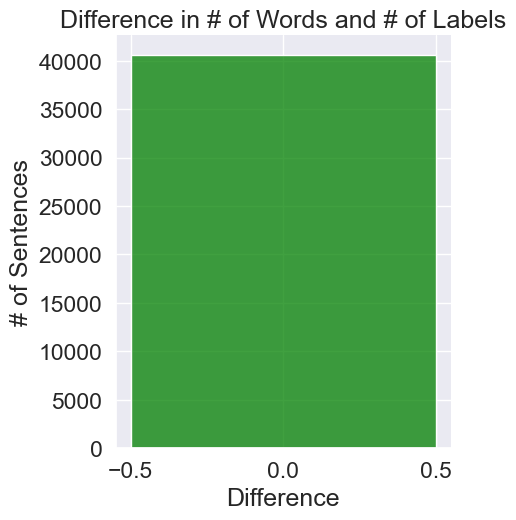


Stats for length of Tokens
Minimum difference in num of words and num of labels: 0
Maximum difference in num of words and num of labels: 0
Median difference in num of words and num of labels: 0


In [205]:
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.figure(figsize=(24, 24))
plt.rcParams["figure.figsize"] = (10,5)

words_labels_diff = data['words_labels_diff'].values.tolist()

min_words_labels_diff = min(words_labels_diff)
max_words_labels_diff = max(words_labels_diff)
median_words_labels_diff = int(np.median(words_labels_diff))

# Plot the distribution of comment lengths.
sns.displot(words_labels_diff, kde=False, rug=False,color='green')

plt.title('Difference in # of Words and # of Labels')
plt.xlabel('Difference')
plt.ylabel('# of Sentences')
plt.show()

print("\nStats for length of Tokens")
print(f"Minimum difference in num of words and num of labels: {min_words_labels_diff}") 
print(f"Maximum difference in num of words and num of labels: {max_words_labels_diff}") 
print(f"Median difference in num of words and num of labels: {median_words_labels_diff}")

#### 13.2. Histogram of length of tokenized sentence (# of tokens created by tokenizer)

<Figure size 2400x2400 with 0 Axes>

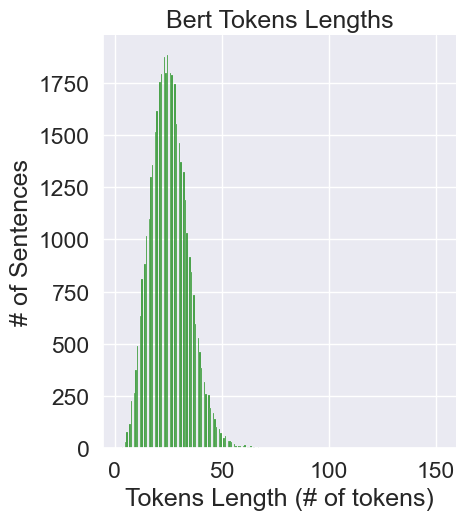


Stats for length of Bert Tokens
Minimum Tokens length: 2
Maximum Tokens length: 152
Median Tokens length: 25


In [206]:
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.figure(figsize=(24, 24))
plt.rcParams["figure.figsize"] = (10,5)

token_lens = data['num_tokens'].values.tolist()

min_token_len = min(token_lens)
max_token_len = max(token_lens)
median_token_len = int(np.median(token_lens))

# Plot the distribution of comment lengths.
sns.displot(token_lens, kde=False, rug=False,color='green')

plt.title('Bert Tokens Lengths')
plt.xlabel('Tokens Length (# of tokens)')
plt.ylabel('# of Sentences')
plt.show()

print("\nStats for length of Bert Tokens")
print(f"Minimum Tokens length: {min_token_len}") 
print(f"Maximum Tokens length: {max_token_len}") 
print(f"Median Tokens length: {median_token_len}")

#### 13.3 Histogram of difference in length between sentence lnegth and bert tokenized sentence length

<Figure size 2400x2400 with 0 Axes>

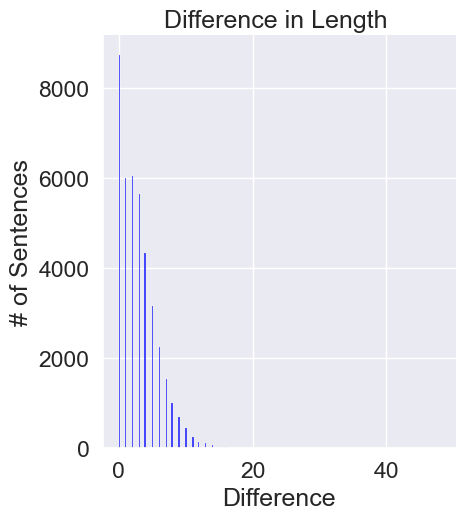


Stats for length difference between Bert Tokens and sentence length
Minimum difference in num of tokens and num of words: 0
Maximum difference in num of tokens and num of words: 48
Median difference in num of tokens and num of words: 2


In [207]:
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.figure(figsize=(24, 24))
plt.rcParams["figure.figsize"] = (10,10)

words_tokens_diff = data['words_tokens_diff'].values.tolist()

min_words_tokens_diff = min(words_tokens_diff)
max_words_tokens_diff = max(words_tokens_diff)
median_words_tokens_diff = int(np.median(words_tokens_diff))

# Plot the distribution of comment lengths.
sns.displot(words_tokens_diff, kde=False, rug=False,color='blue')

plt.title('Difference in Length ')
plt.xlabel('Difference')
plt.ylabel('# of Sentences')
plt.show()

print("\nStats for length difference between Bert Tokens and sentence length")
print(f"Minimum difference in num of tokens and num of words: {min_words_tokens_diff}") 
print(f"Maximum difference in num of tokens and num of words: {max_words_tokens_diff}") 
print(f"Median difference in num of tokens and num of words: {median_words_tokens_diff}")

### 14. Setting meaningfull Max Len 

#### 14.1. Compute the number of sentences where tokenized length is greater than a certain threshold

##### 14.1. a) threshold = 78

In [208]:
len_thresh = 78
data[data['num_tokens']> len_thresh]

,sentence,labels,num_words,num_labels,bert_tokens,num_tokens,words_tokens_diff,words_labels_diff
22391,"Fisheries in 2006 - 7 landed 1,26,976 metric t...","O,O,B-tim,I-tim,I-tim,O,O,O,O,O,O,O,O,O,O,O,O,...",104,104,"fisheries in 2006 - 7 landed 1 , 26 , 97 ##6 m...",152,48,0
26061,"Ratners Group PLC , a fast-growing , acquisiti...","B-org,I-org,I-org,O,O,O,O,O,O,O,O,O,O,O,O,O,O,...",58,58,"rat ##ners group plc , a fast - growing , acqu...",79,21,0
33311,On his departure the Farmer grievously lamente...,"O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,...",81,81,on his departure the farmer gr ##ie ##vo ##usl...,88,7,0
39903,"According to the U.S. Department of Commerce ,...","O,O,O,B-org,I-org,I-org,I-org,O,B-geo,O,O,O,B-...",73,73,according to the u . s . department of commerc...,95,22,0


##### 14.1. b) threshold = 80

In [209]:
len_thresh = 80
data[data['num_tokens']> len_thresh]

,sentence,labels,num_words,num_labels,bert_tokens,num_tokens,words_tokens_diff,words_labels_diff
22391,"Fisheries in 2006 - 7 landed 1,26,976 metric t...","O,O,B-tim,I-tim,I-tim,O,O,O,O,O,O,O,O,O,O,O,O,...",104,104,"fisheries in 2006 - 7 landed 1 , 26 , 97 ##6 m...",152,48,0
33311,On his departure the Farmer grievously lamente...,"O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,...",81,81,on his departure the farmer gr ##ie ##vo ##usl...,88,7,0
39903,"According to the U.S. Department of Commerce ,...","O,O,O,B-org,I-org,I-org,I-org,O,B-geo,O,O,O,B-...",73,73,according to the u . s . department of commerc...,95,22,0


##### 14.2. c) threshold = 128

In [210]:
len_thresh = 128
data[data['num_tokens']> len_thresh]

,sentence,labels,num_words,num_labels,bert_tokens,num_tokens,words_tokens_diff,words_labels_diff
22391,"Fisheries in 2006 - 7 landed 1,26,976 metric t...","O,O,B-tim,I-tim,I-tim,O,O,O,O,O,O,O,O,O,O,O,O,...",104,104,"fisheries in 2006 - 7 landed 1 , 26 , 97 ##6 m...",152,48,0


##### Conclusion:
1. Only 1 sentences have tokenized length greater than 128.
2. The one with the largest difference in length is 48 is also present

So we can safely keep the max seq len or max len to be 128

#### 14.2 Dropping the unwanted columns and resetting the index 

In [211]:
data = data[["sentence", "labels"]].drop_duplicates().reset_index(drop=True)
display(data.head())
print(f"\n Nnumber of sentences in clean dataframe: {len(data)}")

,sentence,labels
0,Thousands of demonstrators have marched throug...,"O,O,O,O,O,O,B-geo,O,O,O,O,O,B-geo,O,O,O,O,O,B-..."
1,Families of soldiers killed in the conflict jo...,"O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,B-per,O,O,..."
2,They marched from the Houses of Parliament to ...,"O,O,O,O,O,O,O,O,O,O,O,B-geo,I-geo,O"
3,The protest comes on the eve of the annual con...,"O,O,O,O,O,O,O,O,O,O,O,B-geo,O,O,B-org,I-org,O,..."
4,The party is divided over Britain 's participa...,"O,O,O,O,O,B-gpe,O,O,O,O,B-geo,O,O,O,O,O,O,O,B-..."



 Nnumber of sentences in clean dataframe: 40577


#### 14.3. Let's verify that a random sentence and its corresponding tags are correct:

In [212]:
data.iloc[21].sentence

'Officials will not say how many troops have arrived in the Sunni Arab and Kurdish city , where bombings last week killed at least 34 people and wounded more than 200 .'

In [213]:
data.iloc[21].labels

'O,O,O,O,O,O,O,O,O,O,O,B-geo,I-geo,O,B-geo,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O'

##### peek into data

In [214]:
data.head()

,sentence,labels
0,Thousands of demonstrators have marched throug...,"O,O,O,O,O,O,B-geo,O,O,O,O,O,B-geo,O,O,O,O,O,B-..."
1,Families of soldiers killed in the conflict jo...,"O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,B-per,O,O,..."
2,They marched from the Houses of Parliament to ...,"O,O,O,O,O,O,O,O,O,O,O,B-geo,I-geo,O"
3,The protest comes on the eve of the annual con...,"O,O,O,O,O,O,O,O,O,O,O,B-geo,O,O,B-org,I-org,O,..."
4,The party is divided over Britain 's participa...,"O,O,O,O,O,B-gpe,O,O,O,O,B-geo,O,O,O,O,O,O,O,B-..."


## E. Explore distributions of Labels

### 1. Create a new dataframe to explore distributions of labels

In [215]:
# create a new dataframe named as balance dataframe (bal_df) containing sentence id (s_id) and labels
bal_df = pd.DataFrame(columns=['s_id', 'labels'])

### 2. Set the 'label' column to contain list of labels and 's_id' column as index

In [216]:
# split the labels column of data into list of labels
bal_df['labels'] = data['labels'].apply(lambda x: x.split(','))
# set 's_id' column to be the index column of data 
bal_df['s_id'] = data.index

# display the bal df
display(bal_df.head())

,s_id,labels
0,0,"[O, O, O, O, O, O, B-geo, O, O, O, O, O, B-geo..."
1,1,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
2,2,"[O, O, O, O, O, O, O, O, O, O, O, B-geo, I-geo..."
3,3,"[O, O, O, O, O, O, O, O, O, O, O, B-geo, O, O,..."
4,4,"[O, O, O, O, O, B-gpe, O, O, O, O, B-geo, O, O..."


### 3. Explode the labels column to have one only one label per row

In [217]:
# explode the labels column
bal_df = bal_df.explode('labels')

# display the bal df
display(bal_df.head())

,s_id,labels
0,0,O
0,0,O
0,0,O
0,0,O
0,0,O


### 4. Create the dummies for labels column

In [218]:
bal_df = pd.get_dummies(bal_df)

# display the bal df
display(bal_df.head())

,s_id,labels_B-geo,labels_B-gpe,labels_B-org,labels_B-per,labels_B-tim,labels_I-geo,labels_I-org,labels_I-per,labels_I-tim,labels_O
0,0,False,False,False,False,False,False,False,False,False,True
0,0,False,False,False,False,False,False,False,False,False,True
0,0,False,False,False,False,False,False,False,False,False,True
0,0,False,False,False,False,False,False,False,False,False,True
0,0,False,False,False,False,False,False,False,False,False,True


### 5. Count the frequency of each label for every sentence

In [219]:
# Group by 's_id' column and aggregagte using sum
bal_df = bal_df.groupby(['s_id'], as_index=True).sum()

# display the information
display(bal_df.head())

,labels_B-geo,labels_B-gpe,labels_B-org,labels_B-per,labels_B-tim,labels_I-geo,labels_I-org,labels_I-per,labels_I-tim,labels_O
s_id,,,,,,,,,,
0,2,1,0,0,0,0,0,0,0,21
1,0,0,0,1,0,0,0,0,0,29
2,1,0,0,0,0,1,0,0,0,12
3,2,1,1,0,0,0,1,0,0,20
4,1,2,0,0,0,0,0,0,0,21


### 6. Descriptive Statistics of each label

In [220]:
# Get the descriptive statisitcs of each label
bal_df.describe()

,labels_B-geo,labels_B-gpe,labels_B-org,labels_B-per,labels_B-tim,labels_I-geo,labels_I-org,labels_I-per,labels_I-tim,labels_O
count,40577.000000,40577.000000,40577.000000,40577.000000,40577.000000,40577.000000,40577.000000,40577.000000,40577.000000,40577.000000
mean,0.922912,0.389876,0.494196,0.416615,0.498977,0.182024,0.412327,0.422801,0.160214,18.900904
std,1.010552,0.650849,0.718085,0.669881,0.652211,0.494837,0.999832,0.864123,0.563877,6.883792
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,23.000000
max,10.000000,17.000000,8.000000,6.000000,7.000000,12.000000,18.000000,10.000000,12.000000,88.000000


### 7. Plot the kernel density plots for each label

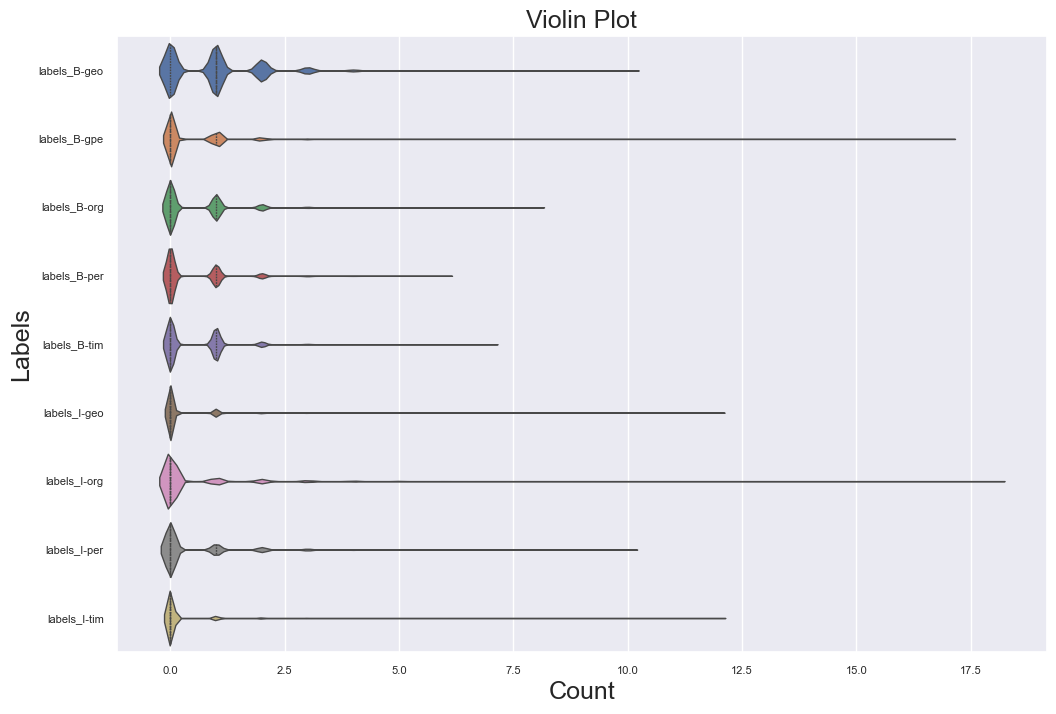

In [221]:
# set the figure dimensions and labels, label size and title
fig, ax = plt.subplots(figsize=(12, 8))
ax.yaxis.set_tick_params(labelsize = 8)
ax.xaxis.set_tick_params(labelsize = 8)
ax.set(xlabel='Count', ylabel='Labels', title='Violin Plot')
# build the plot
g = sns.violinplot(data=bal_df.loc[:, bal_df.columns != 'labels_O'], linewidth=1, inner="quart", orient='h')
# show the plot
plt.show()

### 8. Frequency of each label

In [222]:
# count the frequency of each label in ascending order
labels_counts = bal_df.sum(axis=0).sort_values(ascending=False)

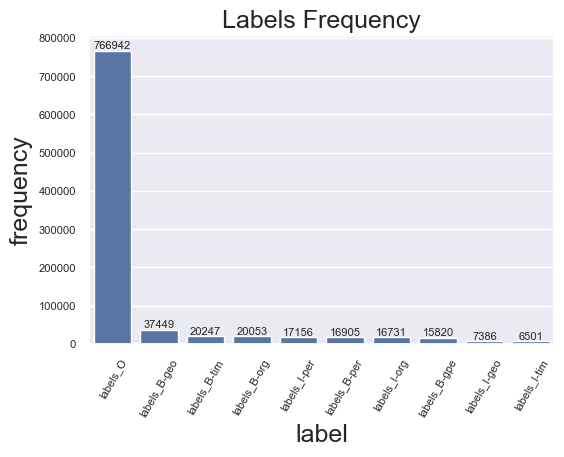

In [223]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.yaxis.set_tick_params(labelsize = 8)
ax.xaxis.set_tick_params(labelsize = 8)
plt.xticks(rotation=60)
g = sns.barplot(x=labels_counts.index, y=labels_counts.values, ax=ax)
ax.set(xlabel='label', ylabel='frequency', title='Labels Frequency')
ax.bar_label(ax.containers[0], fontsize=8)
plt.show()
#fig.savefig('n_label_freq.png', bbox_inches='tight', dpi=1600)

## F. Stratified (or Balanced) Split

### 1. Helper Functions to Create Balanced Split function 

In [224]:
# create multilabel binarizer
mlb = MultiLabelBinarizer(classes=list(label2id.keys()))

# Function to create stratified split
def balanced_split(df, mlb, test_size):
    ind_ = np.expand_dims(np.arange(len(df)), axis=1)
    # series of unique labels
    unique_labels_ = df['labels'].apply(lambda x: set(itertools.chain.from_iterable([x.split(',')])))
    labels_ohe_ = mlb.fit_transform(unique_labels_)
    ind_train, _, ind_test, _ = iterative_train_test_split(
        ind_, labels_ohe_, test_size
    )
    return df.iloc[ind_train[:, 0]], df.iloc[ind_test[:, 0]]

### 2. Spliting the Dataset into training, validation and test dataset

#### 2. a) All Data - Seen Data(80%) + Unseen/Test Data (20%)

In [225]:
seen_df, test_df = balanced_split(data, mlb, test_size=0.2)

##### Check the size of each data

In [226]:
print(f"Full Dataset size: {len(data)}")
print(f"Seen Dataset size: {len(seen_df)}")
print(f"Test Data Size: {len(test_df)}")

Full Dataset size: 40577
Seen Dataset size: 32463
Test Data Size: 8114


#### 2. b) Seen Data - Training Data(90%) + Validation Data (10%)

In [227]:
train_df, valid_df = balanced_split(seen_df, mlb, test_size=0.1)

##### Check the size of each data

In [228]:
print(f"Seen Dataset size: {len(seen_df)}")
print(f"Train Dataset size: {len(train_df)}")
print(f"Valid Data Size: {len(valid_df)}")

Seen Dataset size: 32463
Train Dataset size: 29217
Valid Data Size: 3246


#### 2. c) FULL Data - TRAIN Data + VALID Data + TEST Data

In [229]:
# check the size of each data
print("FULL Dataset: {}".format(data.shape))
print("TRAIN Dataset: {}".format(train_df.shape))
print("VALID Dataset: {}".format(valid_df.shape))
print("TEST Dataset: {}".format(test_df.shape))

FULL Dataset: (40577, 2)
TRAIN Dataset: (29217, 2)
VALID Dataset: (3246, 2)
TEST Dataset: (8114, 2)


##### Reset the indices

In [230]:
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

## G. Explore Distribution of Labels - Training, Validation and Testing Data

In [231]:
# one hot encoding of unique labels for trainig data
unique_train_labels_ohe = mlb.transform(train_df['labels'].apply(lambda x: set(itertools.chain.from_iterable([x.split(',')]))))

# one hot encoding of unique labels for validation data
unique_valid_labels_ohe = mlb.transform(valid_df['labels'].apply(lambda x: set(itertools.chain.from_iterable([x.split(',')]))))

# one hot encoding of unique labels for testing data
unique_test_labels_ohe = mlb.transform(test_df['labels'].apply(lambda x: set(itertools.chain.from_iterable([x.split(',')]))))

#### 1. Check distributions of 1st order 

In [232]:
# compute number of samples
num_train_samples = unique_train_labels_ohe.shape[0]
num_valid_samples = unique_valid_labels_ohe.shape[0]
num_test_samples = unique_test_labels_ohe.shape[0]

# compute number of samples for each unique label
train_labels_count = unique_train_labels_ohe.sum(axis=0)
valid_labels_count = unique_valid_labels_ohe.sum(axis=0)
test_labels_count = unique_test_labels_ohe.sum(axis=0)

# compute proportion of samples for each unique label
prop_train_labels = train_labels_count/num_train_samples
prop_valid_labels = valid_labels_count/num_valid_samples
prop_test_labels = test_labels_count/num_test_samples


print("Training Data")
print("==============")
print(f"Total num of training samples: {num_train_samples}")
print(f"Total num of each label: {train_labels_count}")
print(f"Proportions of each label: {prop_train_labels}\n")

print("Validation Data")
print("==============")
print(f"Total num of validation samples: {num_valid_samples}")
print(f"Total num of each label: {valid_labels_count}")
print(f"Proportions of each label: {prop_valid_labels}\n")

print("Testing Data")
print("===============")
print(f"Total num of training samples: {num_test_samples}")
print(f"Total num of each label: {test_labels_count}")
print(f"Proportions of each label: {prop_test_labels}")

Training Data
Total num of training samples: 29217
Total num of each label: [29211 17483  9207  9674  4313 11288  6116 12324  7614  3047]
Proportions of each label: [0.99979464 0.5983845  0.31512476 0.3311086  0.14761954 0.38635041
 0.20933018 0.42180922 0.2606017  0.1042886 ]

Validation Data
Total num of validation samples: 3246
Total num of each label: [3246 1943 1023 1074  492 1254  650 1402  855  339]
Proportions of each label: [1.         0.59858287 0.31515712 0.33086876 0.15157116 0.38632163
 0.20024646 0.4319162  0.26340111 0.10443623]

Testing Data
Total num of training samples: 8114
Total num of each label: [8114 4857 2558 2685 1210 3135 1683 3453 2124  846]
Proportions of each label: [1.         0.59859502 0.31525758 0.33090954 0.14912497 0.38636924
 0.20741928 0.42556076 0.26176978 0.10426423]


#### 1a. Create the proportion dataFrame for training, validation and testing data

In [233]:
# create dict for proportions of each label
prop_data = {
    'labels' : list(label2id.keys()),
    'train' : prop_train_labels,
    'valid' : prop_valid_labels,
    'test' : prop_test_labels
}

# create dataframe
prop_df = pd.DataFrame.from_dict(prop_data)

# display
display(prop_df)

,labels,train,valid,test
0,O,0.999795,1.000000,1.000000
1,B-geo,0.598385,0.598583,0.598595
2,B-gpe,0.315125,0.315157,0.315258
3,B-per,0.331109,0.330869,0.330910
4,I-geo,0.147620,0.151571,0.149125
5,B-org,0.386350,0.386322,0.386369
6,I-org,0.209330,0.200246,0.207419
7,B-tim,0.421809,0.431916,0.425561
8,I-per,0.260602,0.263401,0.261770
9,I-tim,0.104289,0.104436,0.104264


#### 1b. Plot distribution of proportions across each label for training, validation and testing data

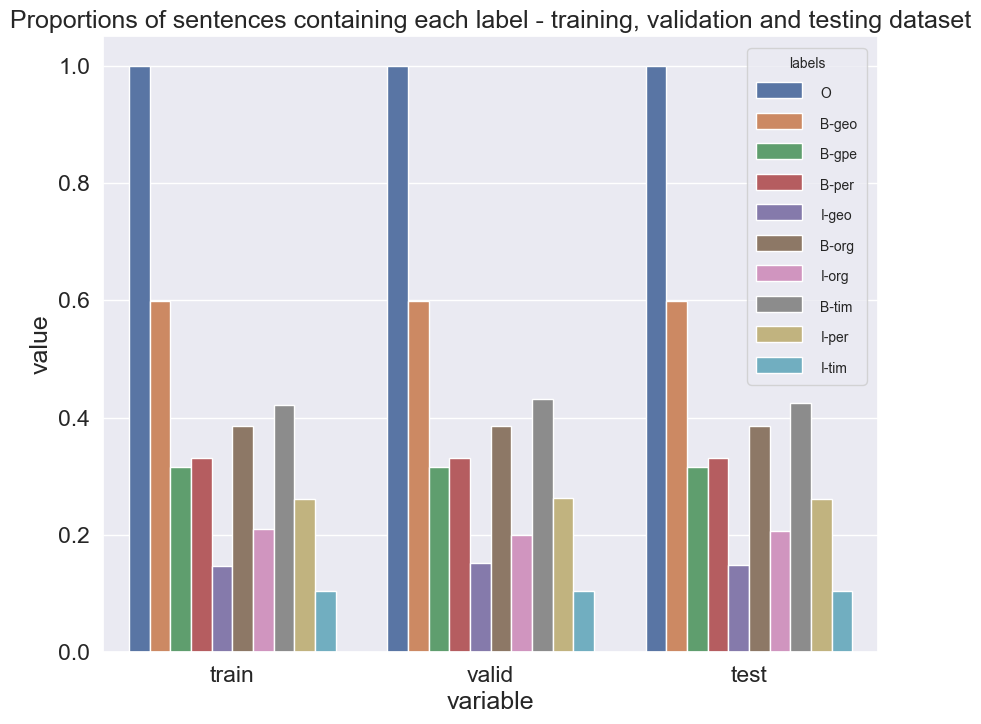

In [234]:
fig, ax = plt.subplots(figsize=(10, 8))
g = sns.barplot(
    data=prop_df.melt(id_vars = ["labels"], value_vars=["train", "valid", "test"]),
    y="value", x="variable", hue="labels", errorbar=None
)

# for legend text
plt.setp(g.get_legend().get_texts(), fontsize='10')  
 
# for legend title
plt.setp(g.get_legend().get_title(), fontsize='10')
plt.title("Proportions of sentences containing each label - training, validation and testing dataset")

plt.show()

#### 2. Check distributions of 2nd order 

In [235]:
from collections import Counter
from skmultilearn.model_selection.measures import get_combination_wise_output_matrix

label_combination_df = pd.DataFrame({
    'train': Counter(str(combination) for row in get_combination_wise_output_matrix(unique_train_labels_ohe, order=2) for combination in row),
    'valid': Counter(str(combination) for row in get_combination_wise_output_matrix(unique_valid_labels_ohe, order=2) for combination in row),
    'test' : Counter(str(combination) for row in get_combination_wise_output_matrix(unique_test_labels_ohe, order=2) for combination in row),
}).T.fillna(0.0).astype('float')

# compute proportions
label_combination_df.loc['train'] = label_combination_df.loc['train']/num_train_samples
label_combination_df.loc['valid'] = label_combination_df.loc['valid']/num_valid_samples
label_combination_df.loc['test'] = label_combination_df.loc['test']/num_test_samples

label_combination_df

,"(0, 3)","(3, 3)","(0, 0)","(0, 1)","(1, 2)","(1, 1)","(0, 2)","(2, 2)","(5, 5)","(0, 6)",...,"(7, 9)","(9, 9)","(0, 9)","(2, 9)","(2, 4)","(4, 7)","(6, 9)","(4, 9)","(3, 4)","(4, 8)"
train,0.330903,0.331109,0.999795,0.598385,0.172708,0.598385,0.315125,0.315125,0.386350,0.209330,...,0.104289,0.104289,0.104289,0.025328,0.039908,0.057809,0.019509,0.014170,0.039942,0.032926
valid,0.330869,0.330869,1.000000,0.598583,0.180530,0.598583,0.315157,0.315157,0.386322,0.200246,...,0.104436,0.104436,0.104436,0.025570,0.041282,0.065311,0.017252,0.014479,0.042514,0.036661
test,0.330910,0.330910,1.000000,0.598595,0.187700,0.598595,0.315258,0.315258,0.386369,0.207419,...,0.104264,0.104264,0.104264,0.025511,0.040547,0.059404,0.020705,0.014420,0.039931,0.033153


#### 3. Check distribution of 3rd order 

In [236]:
from collections import Counter
from skmultilearn.model_selection.measures import get_combination_wise_output_matrix

label_combination_df = pd.DataFrame({
    'train': Counter(str(combination) for row in get_combination_wise_output_matrix(unique_train_labels_ohe, order=3) for combination in row),
    'valid': Counter(str(combination) for row in get_combination_wise_output_matrix(unique_valid_labels_ohe, order=3) for combination in row),
    'test' : Counter(str(combination) for row in get_combination_wise_output_matrix(unique_test_labels_ohe, order=3) for combination in row),
}).T.fillna(0.0).astype('float')

# compute proportions
label_combination_df.loc['train'] = label_combination_df.loc['train']/num_train_samples
label_combination_df.loc['valid'] = label_combination_df.loc['valid']/num_valid_samples
label_combination_df.loc['test'] = label_combination_df.loc['test']/num_test_samples

label_combination_df

,"(0, 0, 0)","(0, 3, 3)","(3, 3, 3)","(0, 0, 3)","(2, 2, 2)","(1, 1, 2)","(1, 2, 2)","(0, 0, 2)","(0, 1, 2)","(0, 2, 2)",...,"(2, 4, 6)","(2, 3, 4)","(3, 6, 9)","(6, 8, 9)","(3, 4, 9)","(4, 6, 8)","(2, 6, 9)","(2, 4, 8)","(4, 8, 9)","(2, 4, 9)"
train,0.999795,0.330903,0.331109,0.330903,0.315125,0.172708,0.172708,0.315125,0.172708,0.315125,...,0.006572,0.012253,0.005955,0.004449,0.003628,0.007564,0.004929,0.010644,0.002978,0.003183
valid,1.000000,0.330869,0.330869,0.330869,0.315157,0.180530,0.180530,0.315157,0.180530,0.315157,...,0.006778,0.010783,0.004313,0.003389,0.005853,0.005853,0.004929,0.010166,0.004621,0.003081
test,1.000000,0.330910,0.330910,0.330910,0.315258,0.187700,0.187700,0.315258,0.187700,0.315258,...,0.006778,0.011338,0.006285,0.004560,0.003944,0.005916,0.005053,0.009983,0.002711,0.003574


## H. Modelling

### 1. Modelling Parameters

In [237]:
# Max sequence length
MAX_LEN = 128

# Batch Size
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 4
TEST_BATCH_SIZE = 4

# Training Epochs
EPOCHS = 10

# Optimizer params
LEARNING_RATE = 1e-06
ADAMS_EPSILON = 1e-7

# clipping grad norms
MAX_GRAD_NORM = 1.0

# tokenizer to use
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', clean_up_tokenization_spaces=True)

### 2. Preparing the dataset and dataloader

#### 2.1. Function to retain labels

In [238]:
def tokenize_and_retain_labels(sentence, text_labels, tokenizer):
    """
    Tokenization at the word piece level complicates the process
    of aligning word labels with their corresponding individual word
    pieces. This method processes each word sequentially, facilitating
    the accurate retention of labels for each subword. While this approach
    may result in a slight increase in processing time, it ultimately
    contributes to improved accuracy for our model.
    """

    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

#### 2.2 Custom NER Dataset Class

In [239]:
class NerDataset(Dataset):
    """
    Custom dataset implementation to get (text,labels) tuples
    Inputs:
    - df : dataframe with columns [sentence, labels]
    """
    def __init__(self, df, tokenizer, max_len):
        if not isinstance(df, pd.DataFrame):
            raise TypeError('Input should be a dataframe')
            
        if "labels" not in df.columns or "sentence" not in df.columns:
            raise ValueError("Dataframe should contain 'labels' and 'sentence' columns")

        self.data = df
        self.len = len(df)
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
            return self.len

    def __getitem__(self, idx):
        # step 1: Tokenize and map corresponding labels
        # get the sentence data at index idx
        sentence = self.data['sentence'][idx].strip().split(' ')
        # get the words labels at index idx
        word_labels = self.data['labels'][idx].split(',')
        
        # Iterate through each tokenized sentence and labels
        token_sent, token_labl = tokenize_and_retain_labels(sentence, word_labels, self.tokenizer)
        
        # compute input ids and attention masks
        encoded_sent_dict = tokenizer.encode_plus(' '.join(sentence),     # Sentence to encode.
                                                  add_special_tokens = True,     # Add '[CLS]' and '[SEP]'
                                                  truncation=True,
                                                  max_length = self.max_len,     # Pad & truncate all sentences.
                                                  padding='max_length',
                                                  return_attention_mask = True,     # Construct attn. masks.
                                                  return_tensors = 'pt',     # Return pytorch tensors.
                                                 )
            
        input_ids = encoded_sent_dict['input_ids'][0]
        attn_masks = encoded_sent_dict['attention_mask'][0]
            
        label_ids = [-100]*self.max_len
        for i, tok in enumerate(token_labl):
            if label2id.get(tok) != None and i<self.max_len-1:
                label_ids[i+1]=label2id.get(tok)
        
        # Ensure that last label_id is -100 coressponding to [SEP] token
        label_ids[-1] = -100
                
        items = {
            'input_ids': input_ids,
            'attn_masks': attn_masks,
            'labels': torch.tensor(label_ids, dtype=torch.long)
        }

        return items

#### 2.3. Create  Train Dataset, Valid Dataset and Test Dataset

In [240]:
# create train dataset
train_dataset = NerDataset(train_df, tokenizer, MAX_LEN)
# create validation dataset
valid_dataset = NerDataset(valid_df, tokenizer, MAX_LEN)
# create test dataset
test_dataset = NerDataset(test_df, tokenizer, MAX_LEN)

#### 2.4. Create Train DataLoader, Valid DataLoader and Test DataLoader

In [241]:
# set the batch size for train, valid and test dataloader
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True
               }

valid_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': False
               }

test_params = {'batch_size': TEST_BATCH_SIZE,
                'shuffle': False
              }

# create the train dataloader
train_dataloader = DataLoader(train_dataset, **train_params)
# create the validation dataloader
valid_dataloader = DataLoader(valid_dataset, **test_params)
# create the test dataloader
test_dataloader = DataLoader(test_dataset, **test_params)

### 3. Create Model
We present a novel language representation model known as BERT, which stands for Bidirectional Encoder Representations from Transformers. In contrast to other recent models, BERT is specifically engineered to pre-train deep bidirectional representations from unlabeled text by simultaneously considering both left and right contexts across all layers. Consequently, the pre-trained BERT model can be easily fine-tuned by adding a single output layer, enabling the development of cutting-edge models for various tasks, including question answering and language inference, without the need for significant alterations to the task-specific architecture.

In [242]:
# create BERT model
model = BertForTokenClassification.from_pretrained('bert-base-uncased', 
                                                   num_labels=len(id2label),
                                                   id2label=id2label,
                                                   label2id=label2id)
# move the model to the device used
model.to(device)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

### 4. Set the Optimizer
<b> Optimizer - AdamW:</b>

<font color=brown>AdamW</font> is a stochastic optimization method that modifies the typical implementation of weight decay
in Adam, by decoupling weight decay from the gradient update.

<b>Learning Rate:</b>

<font color=brown>Learning rate</font> is a tuning parameter in machine learning and statistics that controls how much
a model's parameters adjust during each iteration of an optimization algorithm. It's a floating
point number that's usually between 0.01 and 0.1

<b>Adam Epsilon:</b>

The parameter <font color=brown>epsilon</font> shows up in the update step.

θ_t <- θ_{t-1} - α • mhat_t / (sqrt(vhat_t) + ε)

It is primarily used as a guard against a zero second second moment causing a division by zero case. If it is too large it will bias the moment estimation.

In [243]:
# set the learning rate
learning_rate = LEARNING_RATE

# set the adam's epsilon
# The term added to the denominator to improve numerical stability
adam_epsilon = ADAMS_EPSILON

# Load the AdamW optimizer
optimizer = AdamW(model.parameters(),
                  lr = learning_rate, # args.learning_rate 
                  eps = adam_epsilon # args.adam_epsilon 
                )

print(f"learning rate: {learning_rate}")
print(f"adams epsilon: {adam_epsilon}")

learning rate: 1e-06
adams epsilon: 1e-07


### 5. Set the Scheduler
<p>
A <font color=brown><b>scheduler</b></font> is to make <b>learning rate</b> <font color=blue>adaptive</font> to the gradient descent optimization procedure, so you can increase performance and reduce training time.
    
In <font color=brown>PyTorch</font>, a model is updated by an optimizer and learning rate is a parameter of the optimizer.

<i>Learning rate schedule is an algorithm to update the learning rate in an optimizer</i>.
</p>

In [244]:
# Number of training epochs 
epochs = EPOCHS

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

print(f"total steps: {total_steps}")

# create the learning scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

total steps: 9140


### 6. Create the training loop 
<p>
A typical <font color=brown>training loop</font> in PyTorch iterates over the batches for a given number of epochs.

- In each batch iteration, we first compute the forward pass to obtain the neural network outputs.
- Then, we reset the gradient from the previous iteration and perform backpropagation to obtain
the gradient of the loss with respect to the model weights.
- Finally, we update the weights based on the loss gradients using stochastic gradient descent.

Since we are using learning scheduler for the adaptive learning rate, we call <font color=brown>scheduler.step()</font> to
update the learning rate (as per the learning scheduler) after every epoch.
</p>

In [245]:
def train_loop(model, train_dataloader, optimizer, epochs, device=torch.device('cpu'), seed_val=42):
    
    # set the random seeds
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)

    # initially set best model to model
    # This model corresponds to the min loss model
    best_model = model
    # min loss function (initially set to a large value)
    min_train_loss = 10000000
    

    # store loss values for each epoch
    loss_values = []

    for epoch_i in range(0, epochs):
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        print('Training...')
        # training loss
        total_loss = 0
    
        # train mode
        model.train()

        for step, batch in enumerate(train_dataloader):
            if step%40 == 0 and not step == 0:
                # report progress of the training
                print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

                # batch input ids
                batch_input_ids = batch['input_ids'].to(device)
                # batch input mask
                batch_input_mask = batch['attn_masks'].to(device)
                # batch labels
                batch_labels = batch['labels'].to(device)

                # Zero the gradients to start fresh next time
                model.zero_grad()

                # get the output
                outputs = model(batch_input_ids, token_type_ids=None,
                                attention_mask=batch_input_mask, labels=batch_labels)
                loss = outputs[0]
                
                # add the loss
                total_loss += loss.item()
            
                # gradient computing step
                # -----------------------
                # loss.backward() computes dloss/dx for every parameter x which
                # has requires_grad=True. These are accumulated into x.grad
                # for every parameter x.
                loss.backward()

                # clips the norm of the overall gradient by concatenating all
                # parameters passed to the function
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            
                # Tell the optimizer the gradients, then step.
                # Performs a single optimization step (parameter update)
            optimizer.step()

            # We need this step to dynamically change learning rate
            # else it won’t be changed.
            # To introduce a learning rate scheduler,
            # you need to run its step() function in the training loop.
            scheduler.step()
        
        # Compute the average training loss per instance
        avg_train_loss = total_loss / len(train_dataloader)
        loss_values.append(avg_train_loss)
        print("  Average training loss: {0:.4f}".format(avg_train_loss))

        # track the min loss and update the best model accordingly
        if avg_train_loss < min_train_loss:
            print("updating the model")
            min_train_loss = avg_train_loss
            # update the model
            best_model = copy.deepcopy(model)
        print("Minimum Average training loss: {0:.4f}".format(avg_train_loss))

    return loss_values, min_train_loss, best_model

### 7. Training Phase

In [246]:
avg_train_loss, min_avg_train_loss, best_model = train_loop(model, train_dataloader, optimizer,  epochs, device=device, seed_val=42)

======== Epoch 1 / 10 ========
Training...
  Batch    40  of    914.
  Batch    80  of    914.
  Batch   120  of    914.
  Batch   160  of    914.
  Batch   200  of    914.
  Batch   240  of    914.
  Batch   280  of    914.
  Batch   320  of    914.
  Batch   360  of    914.
  Batch   400  of    914.
  Batch   440  of    914.
  Batch   480  of    914.
  Batch   520  of    914.
  Batch   560  of    914.
  Batch   600  of    914.
  Batch   640  of    914.
  Batch   680  of    914.
  Batch   720  of    914.
  Batch   760  of    914.
  Batch   800  of    914.
  Batch   840  of    914.
  Batch   880  of    914.
  Average training loss: 0.0204
updating the model
Minimum Average training loss: 0.0204
======== Epoch 2 / 10 ========
Training...
  Batch    40  of    914.
  Batch    80  of    914.
  Batch   120  of    914.
  Batch   160  of    914.
  Batch   200  of    914.
  Batch   240  of    914.
  Batch   280  of    914.
  Batch   320  of    914.
  Batch   360  of    914.
  Batch   400  of  

### 8. Draw the graph for training loss to see its progress after every epoch

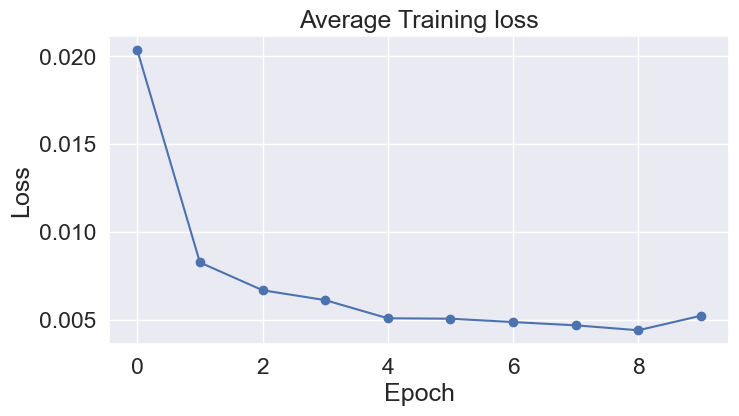

In [247]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(8, 4))
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)

# Plot the learning curve.
plt.plot(avg_train_loss, 'b-o')

# Label the plot.
plt.title("Average Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

#### 8.1. Let see the specification of best model

In [1376]:
print(best_model)

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

## I. Evaluation

### 1. Create the Evaluation Function

In [248]:
def eval_fn(model, test_dataloader):
    # put model in evaluation mode
    model.eval()
    
    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []

    with torch.no_grad():
        for idx, batch in enumerate(test_dataloader):
            
            ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attn_masks'].to(device, dtype = torch.long)
            targets = batch['labels'].to(device, dtype = torch.long)
            
            outputs = model(input_ids=ids, attention_mask=mask, labels=targets)
            loss, eval_logits = outputs.loss, outputs.logits
            
            eval_loss += loss.item()

            nb_eval_steps += 1
            nb_eval_examples += targets.size(0)
        
            if idx % 40==0:
                loss_step = eval_loss/nb_eval_steps
                print(f"Validation loss per 100 evaluation steps: {loss_step}")
              
            # compute evaluation accuracy
            flattened_targets = targets.view(-1) # shape (batch_size * seq_len,)
            active_logits = eval_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)

            # now, use mask to determine where we should compare predictions with
            # targets (includes [CLS] and [SEP] token predictions)
            active_accuracy = mask.view(-1) == 1 # active accuracy is also of shape (batch_size * seq_len,)

            # actual targets
            targets = torch.masked_select(flattened_targets, active_accuracy).cpu().numpy()
            # actual preicted labels
            predictions = torch.masked_select(flattened_predictions, active_accuracy).cpu().numpy()
            

            real_tar_ = []
            real_pred_ = []

            for t,p in zip(targets, predictions):
                if t != -100:
                    real_tar_.append(t)
                    real_pred_.append(p)
            
            eval_labels.extend(real_tar_)
            eval_preds.extend(real_pred_)
            
            tmp_eval_accuracy = accuracy_score(real_tar_, real_pred_)
            eval_accuracy += tmp_eval_accuracy

    
    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps
    print(f"Validation Loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy}")

    return eval_labels, eval_preds

### 2. Check Performance of model on Validation Dataset

In [249]:
true_labels, pred_labels = eval_fn(best_model, valid_dataloader)

Validation loss per 100 evaluation steps: 0.11559396982192993
Validation loss per 100 evaluation steps: 0.21069237180962797
Validation loss per 100 evaluation steps: 0.1974116121361285
Validation loss per 100 evaluation steps: 0.19573622757245687
Validation loss per 100 evaluation steps: 0.201709726877418
Validation loss per 100 evaluation steps: 0.2082493796027196
Validation loss per 100 evaluation steps: 0.20963860329827952
Validation loss per 100 evaluation steps: 0.20809228879687944
Validation loss per 100 evaluation steps: 0.20440610254189215
Validation loss per 100 evaluation steps: 0.20427858004723146
Validation loss per 100 evaluation steps: 0.20348527806664718
Validation loss per 100 evaluation steps: 0.20262921747251028
Validation loss per 100 evaluation steps: 0.19953706348605316
Validation loss per 100 evaluation steps: 0.19733238270266729
Validation loss per 100 evaluation steps: 0.19436683216250092
Validation loss per 100 evaluation steps: 0.1965586005674424
Validation lo

### 3. Compute the classification report 

In [251]:
def print_full_classification_report(true_labels, pred_labels, zero_division=np.nan):
    # computing the accuracy
    accuracy = accuracy_score(y_true=true_labels, y_pred=pred_labels, )

    print("\naccuracy score {:.3%}".format(accuracy))
    
    # compute the macro precision
    macro_precision = precision_score(y_true=true_labels, y_pred=pred_labels, average='macro',
                                      zero_division=zero_division)
    # compute the macro recall
    macro_recall = recall_score(y_true=true_labels, y_pred=pred_labels, average='macro',)
    # compute the macro f1_score
    macro_f1_score = f1_score(y_true = true_labels, y_pred = pred_labels, average='macro')

    print("\n----- macro scores --------")
    print("macro precision score: {:.3%}".format(macro_precision))
    print("macro recall score: {:.3%}".format(macro_recall))
    print("macro f1 score: {:.3%}".format(macro_f1_score))

    # ---- micro scores -------
    micro_precision = precision_score(y_true=true_labels, y_pred=pred_labels, average='micro',
                                      zero_division=zero_division)

    micro_recall = recall_score(y_true=true_labels, y_pred=pred_labels, average='micro')

    micro_f1_score = f1_score(y_true = true_labels, y_pred = pred_labels, average='micro')


    print("\n----- micro scores --------")
    print("micro precision score: {:.2%}".format(micro_precision))
    print("micro recall score: {:.2%}".format(micro_recall))
    print("micro f1 score: {:.2%}".format(micro_f1_score))

    # ------ weighted scores------
    wt_precision = precision_score(y_true=true_labels, y_pred=pred_labels, average='weighted',
                                             zero_division=zero_division)

    wt_recall = recall_score(y_true=true_labels, y_pred=pred_labels, average='weighted')

    wt_f1_score = f1_score(y_true = true_labels, y_pred = pred_labels, average='weighted')

    print("\n----- weighted scores --------")
    print("weighted precision score: {:.2%}".format(wt_precision))
    print("weighted recall score: {:.2%}".format(wt_recall))
    print("weighted f1 score: {:.2%}".format(wt_f1_score))

In [252]:
print("\nEvaluation Metrics for Validation DataSet")
print("=========================================")
print_full_classification_report(true_labels, pred_labels)


Evaluation Metrics for Validation DataSet

accuracy score 94.097%

----- macro scores --------
macro precision score: 79.881%
macro recall score: 76.577%
macro f1 score: 77.804%

----- micro scores --------
micro precision score: 94.10%
micro recall score: 94.10%
micro f1 score: 94.10%

----- weighted scores --------
weighted precision score: 94.04%
weighted recall score: 94.10%
weighted f1 score: 94.01%


### 4. Compute Classification report at label level

In [253]:
from sklearn.metrics import classification_report

clf_report_for_valid = classification_report(y_true=true_labels,
                                             y_pred=pred_labels,
                                             labels=[x for x in range(len(label2id))],
                                             target_names=list(label2id.keys()),
                                             zero_division=0
                                            )
print("\nLabel-Wise Evaluation Metrics for Validation DataSet")
print("Classification Report for each label\n")
print(clf_report_for_valid)


Label-Wise Evaluation Metrics for Validation DataSet
Classification Report for each label

              precision    recall  f1-score   support

           O       0.98      0.98      0.98     65591
       B-geo       0.80      0.87      0.83      4592
       B-gpe       0.87      0.86      0.86      1393
       B-per       0.81      0.85      0.83      2047
       I-geo       0.73      0.61      0.66       742
       B-org       0.70      0.64      0.67      2589
       I-org       0.65      0.57      0.61      1607
       B-tim       0.86      0.82      0.84      1816
       I-per       0.81      0.94      0.87      2589
       I-tim       0.78      0.52      0.63       561

    accuracy                           0.94     83527
   macro avg       0.80      0.77      0.78     83527
weighted avg       0.94      0.94      0.94     83527



### 5. Confusion Matrix

#### 5.1. Compute Multi-Label Confusion Matrix

In [254]:
label_names_ = list(label2id.keys())
label_ids_ = [i for i in range(len(label_names_))]

# compute confusion matrix collectively
cm_for_valid = confusion_matrix(y_true=true_labels,
                                y_pred=pred_labels,
                                labels=label_ids_,
                               )

# compute NORMALIZE (row) confusion matrix collectively
cm_for_valid_norm = confusion_matrix(y_true=true_labels,
                                y_pred=pred_labels,
                                labels=label_ids_,
                                normalize='true'
                               )

df_cm_for_valid = pd.DataFrame(cm_for_valid, index=label_names_, columns=label_names_)
df_cm_for_valid_norm = pd.DataFrame(cm_for_valid_norm, index=label_names_, columns=label_names_)

print("Confusion Matrix DataFrame")
display(df_cm_for_valid)

Confusion Matrix DataFrame


,O,B-geo,B-gpe,B-per,I-geo,B-org,I-org,B-tim,I-per,I-tim
O,64438,139,59,73,39,318,306,124,50,45
B-geo,147,3989,37,81,49,211,13,5,53,7
B-gpe,4,174,1193,0,8,11,3,0,0,0
B-per,75,36,9,1743,1,77,11,0,95,0
I-geo,55,86,5,2,450,4,75,0,64,1
B-org,187,468,55,125,2,1651,45,4,49,3
I-org,200,61,16,35,53,71,923,1,247,0
B-tim,236,41,0,3,1,6,5,1492,6,26
I-per,24,2,2,93,12,1,31,0,2424,0
I-tim,127,15,2,0,0,2,5,117,0,293


#### 5.2 Normalize - Confusion Matrix

In [255]:
print("\nConfusion Matrix DataFrame - Normalize")
display(df_cm_for_valid_norm)


Confusion Matrix DataFrame - Normalize


,O,B-geo,B-gpe,B-per,I-geo,B-org,I-org,B-tim,I-per,I-tim
O,0.982421,0.002119,0.000900,0.001113,0.000595,0.004848,0.004665,0.001891,0.000762,0.000686
B-geo,0.032012,0.868685,0.008057,0.017639,0.010671,0.045949,0.002831,0.001089,0.011542,0.001524
B-gpe,0.002872,0.124910,0.856425,0.000000,0.005743,0.007897,0.002154,0.000000,0.000000,0.000000
B-per,0.036639,0.017587,0.004397,0.851490,0.000489,0.037616,0.005374,0.000000,0.046409,0.000000
I-geo,0.074124,0.115903,0.006739,0.002695,0.606469,0.005391,0.101078,0.000000,0.086253,0.001348
B-org,0.072229,0.180765,0.021244,0.048281,0.000772,0.637698,0.017381,0.001545,0.018926,0.001159
I-org,0.124456,0.037959,0.009956,0.021780,0.032981,0.044182,0.574362,0.000622,0.153703,0.000000
B-tim,0.129956,0.022577,0.000000,0.001652,0.000551,0.003304,0.002753,0.821586,0.003304,0.014317
I-per,0.009270,0.000772,0.000772,0.035921,0.004635,0.000386,0.011974,0.000000,0.936269,0.000000
I-tim,0.226381,0.026738,0.003565,0.000000,0.000000,0.003565,0.008913,0.208556,0.000000,0.522282


#### 5.3 Plot the confusion matrix for Valid Dataset

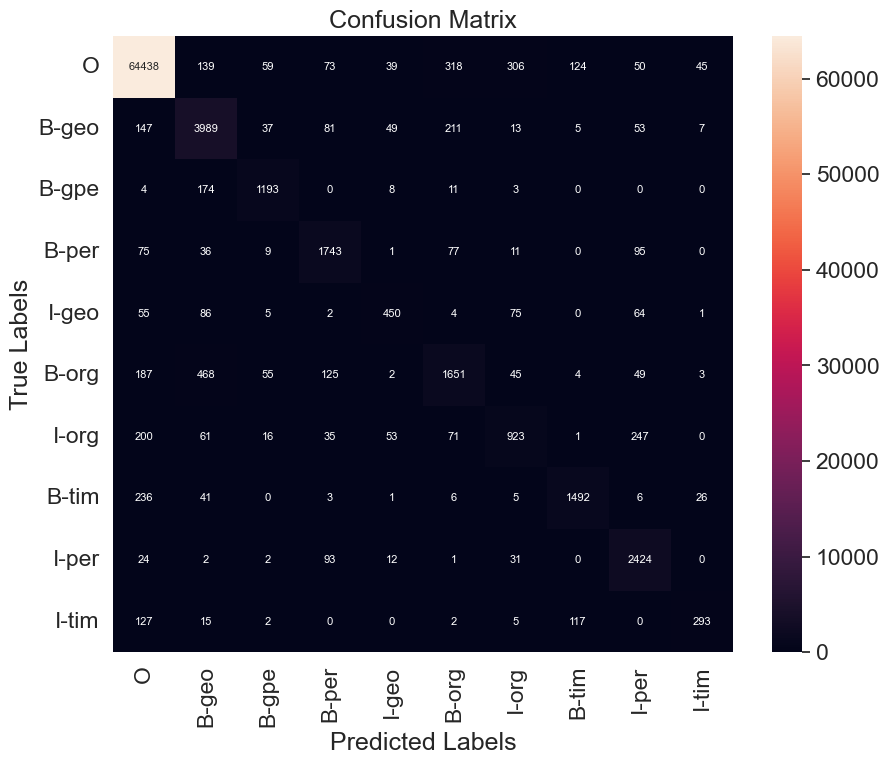

In [262]:
#specify size of heatmap
fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(df_cm_for_valid, annot=True, fmt="g", annot_kws={"size": 8}).set(title='Confusion Matrix')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

# show the plot
plt.show()

#### 5.4. Confusion Matrix for each Label (One Vs All Fashion) - VALID DATASET

In [263]:
# compute multilabel confusion matrix
# Here it will compute cm at the class level
# labels are binarized under a one-vs-rest way
mcm_for_valid = multilabel_confusion_matrix(y_true=true_labels,
                                        y_pred=pred_labels,
                                        labels=label_ids_,
                                       )

# Label wise confusin matrix (one vs all fashion)
for label_, l_cm in zip(label_names_, mcm_for_valid):
    col_names_ = [f"not_{label_}",label_]
    print(f"Validation Dataset - Confusion Matrix for {label_}")
    ldf = pd.DataFrame(l_cm, index=col_names_, columns=col_names_)
    display(ldf)
    print("-----------------------------\n")

Validation Dataset - Confusion Matrix for O


,not_O,O
not_O,16881,1055
O,1153,64438


-----------------------------

Validation Dataset - Confusion Matrix for B-geo


,not_B-geo,B-geo
not_B-geo,77913,1022
B-geo,603,3989


-----------------------------

Validation Dataset - Confusion Matrix for B-gpe


,not_B-gpe,B-gpe
not_B-gpe,81949,185
B-gpe,200,1193


-----------------------------

Validation Dataset - Confusion Matrix for B-per


,not_B-per,B-per
not_B-per,81068,412
B-per,304,1743


-----------------------------

Validation Dataset - Confusion Matrix for I-geo


,not_I-geo,I-geo
not_I-geo,82620,165
I-geo,292,450


-----------------------------

Validation Dataset - Confusion Matrix for B-org


,not_B-org,B-org
not_B-org,80237,701
B-org,938,1651


-----------------------------

Validation Dataset - Confusion Matrix for I-org


,not_I-org,I-org
not_I-org,81426,494
I-org,684,923


-----------------------------

Validation Dataset - Confusion Matrix for B-tim


,not_B-tim,B-tim
not_B-tim,81460,251
B-tim,324,1492


-----------------------------

Validation Dataset - Confusion Matrix for I-per


,not_I-per,I-per
not_I-per,80374,564
I-per,165,2424


-----------------------------

Validation Dataset - Confusion Matrix for I-tim


,not_I-tim,I-tim
not_I-tim,82884,82
I-tim,268,293


-----------------------------



#### ----------------------------- Model Training and Evaluation Ends Here ----------------------------------

## J. Testing - Test Dataset

### 1. Check Performance of Model on Testing Dataset 
<p>Note: Here Validation loss is actually <b>testing loss</b></p>

In [264]:
# Note: Here Validation loss is actually loss on Testing
true_labels, pred_labels = eval_fn(best_model, test_dataloader)

Validation loss per 100 evaluation steps: 0.16373401880264282
Validation loss per 100 evaluation steps: 0.24790753955702957
Validation loss per 100 evaluation steps: 0.2378247428777409
Validation loss per 100 evaluation steps: 0.24698223048928847
Validation loss per 100 evaluation steps: 0.2251442464427178
Validation loss per 100 evaluation steps: 0.21639505615318888
Validation loss per 100 evaluation steps: 0.210839434132691
Validation loss per 100 evaluation steps: 0.21933173969905043
Validation loss per 100 evaluation steps: 0.22146757312316295
Validation loss per 100 evaluation steps: 0.2174438783857672
Validation loss per 100 evaluation steps: 0.21836051291221767
Validation loss per 100 evaluation steps: 0.21739262328726025
Validation loss per 100 evaluation steps: 0.2142998816875311
Validation loss per 100 evaluation steps: 0.21054883942637242
Validation loss per 100 evaluation steps: 0.2089502138555475
Validation loss per 100 evaluation steps: 0.2086261236008114
Validation loss 

### 3. Compute FULL classifcation report 

In [265]:
print("\nEvaluation Metrics for TEST DataSet")
print("=========================================")
print_full_classification_report(true_labels, pred_labels)


Evaluation Metrics for TEST DataSet

accuracy score 94.221%

----- macro scores --------
macro precision score: 80.425%
macro recall score: 77.081%
macro f1 score: 78.307%

----- micro scores --------
micro precision score: 94.22%
micro recall score: 94.22%
micro f1 score: 94.22%

----- weighted scores --------
weighted precision score: 94.14%
weighted recall score: 94.22%
weighted f1 score: 94.12%


### 4. LABEL-WISE Classification report

In [266]:
from sklearn.metrics import classification_report

clf_report_for_test = classification_report(y_true=true_labels,
                                             y_pred=pred_labels,
                                             labels=[x for x in range(len(label2id))],
                                             target_names=list(label2id.keys()),
                                             zero_division=0
                                            )
print("\nLabel-Wise Evaluation Metrics for Validation DataSet")
print("Classification Report for each label\n")
print(clf_report_for_test)


Label-Wise Evaluation Metrics for Validation DataSet
Classification Report for each label

              precision    recall  f1-score   support

           O       0.98      0.98      0.98    164846
       B-geo       0.81      0.88      0.84     11580
       B-gpe       0.86      0.85      0.86      3508
       B-per       0.82      0.84      0.83      5257
       I-geo       0.73      0.65      0.69      1719
       B-org       0.70      0.61      0.65      6587
       I-org       0.65      0.58      0.61      3955
       B-tim       0.85      0.85      0.85      4315
       I-per       0.82      0.94      0.87      6631
       I-tim       0.82      0.53      0.65      1386

    accuracy                           0.94    209784
   macro avg       0.80      0.77      0.78    209784
weighted avg       0.94      0.94      0.94    209784



### 5. Confusion Matrix

#### 5.1. Compute Multi-label Confusion Matrix 

In [267]:
label_names_ = list(label2id.keys())
label_ids_ = [i for i in range(len(label_names_))]

# compute confusion matrix collectively
cm_for_test = confusion_matrix(y_true=true_labels,
                                y_pred=pred_labels,
                                labels=label_ids_,
                               )

# compute NORMALIZE confusion matrix collectively
cm_for_test_norm = confusion_matrix(y_true=true_labels,
                                y_pred=pred_labels,
                                labels=label_ids_,
                               normalize='true'
                               )

df_cm_for_test = pd.DataFrame(cm_for_test, index=label_names_, columns=label_names_)

print("Confusion Matrix DataFrame")
df_cm_for_test

Confusion Matrix DataFrame


,O,B-geo,B-gpe,B-per,I-geo,B-org,I-org,B-tim,I-per,I-tim
O,162068,282,184,161,96,690,784,363,131,87
B-geo,375,10176,104,141,126,495,39,15,100,9
B-gpe,25,429,2983,0,18,50,3,0,0,0
B-per,164,127,25,4438,4,249,15,2,233,0
I-geo,114,175,9,1,1121,7,160,1,129,2
B-org,561,1175,125,386,18,3993,123,8,195,3
I-org,540,120,27,80,144,164,2279,3,597,1
B-tim,482,90,1,3,3,16,9,3647,7,57
I-per,83,5,3,222,12,16,75,0,6215,0
I-tim,356,23,2,2,1,8,6,235,12,741


#### 5.2. Normalize - Confusion Matrix

In [268]:
df_cm_for_test_norm = pd.DataFrame(cm_for_test_norm, index=label_names_, columns=label_names_)
print("\nConfusion Matrix DataFrame - Normalize")
display(df_cm_for_test_norm)


Confusion Matrix DataFrame - Normalize


,O,B-geo,B-gpe,B-per,I-geo,B-org,I-org,B-tim,I-per,I-tim
O,0.983148,0.001711,0.001116,0.000977,0.000582,0.004186,0.004756,0.002202,0.000795,0.000528
B-geo,0.032383,0.878756,0.008981,0.012176,0.010881,0.042746,0.003368,0.001295,0.008636,0.000777
B-gpe,0.007127,0.122292,0.850342,0.000000,0.005131,0.014253,0.000855,0.000000,0.000000,0.000000
B-per,0.031196,0.024158,0.004756,0.844208,0.000761,0.047365,0.002853,0.000380,0.044322,0.000000
I-geo,0.066318,0.101803,0.005236,0.000582,0.652123,0.004072,0.093077,0.000582,0.075044,0.001163
B-org,0.085168,0.178382,0.018977,0.058600,0.002733,0.606194,0.018673,0.001215,0.029604,0.000455
I-org,0.136536,0.030341,0.006827,0.020228,0.036410,0.041466,0.576233,0.000759,0.150948,0.000253
B-tim,0.111703,0.020857,0.000232,0.000695,0.000695,0.003708,0.002086,0.845191,0.001622,0.013210
I-per,0.012517,0.000754,0.000452,0.033479,0.001810,0.002413,0.011311,0.000000,0.937264,0.000000
I-tim,0.256854,0.016595,0.001443,0.001443,0.000722,0.005772,0.004329,0.169553,0.008658,0.534632


#### 5.3 Plot the confusion matrix

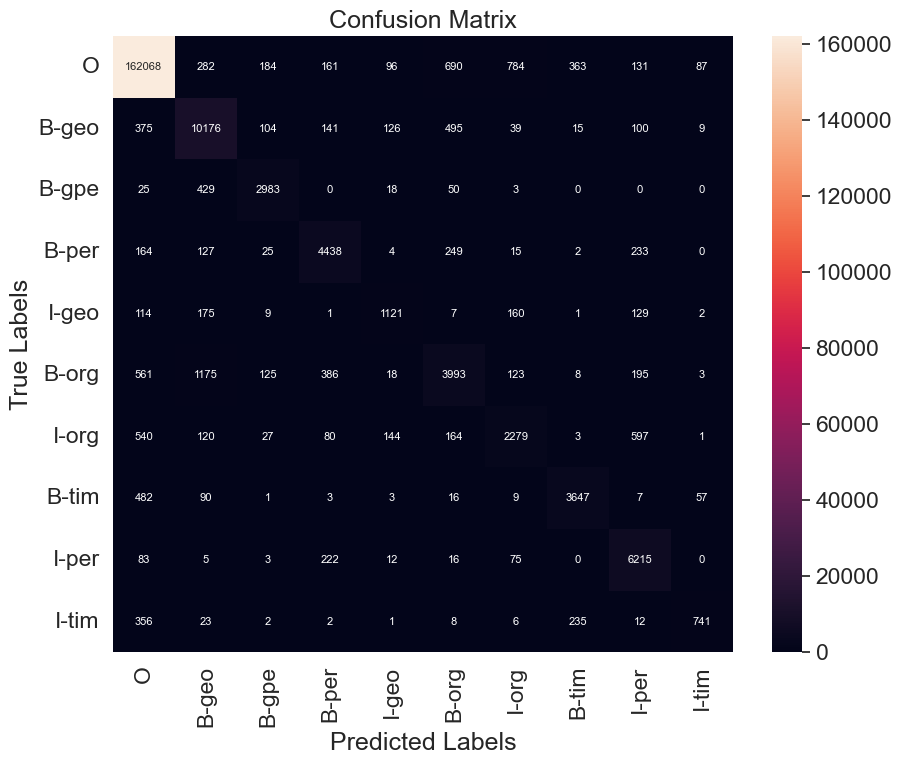

In [270]:
#specify size of heatmap
fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(df_cm_for_test, annot=True, fmt="g", annot_kws={"size": 8}).set(title='Confusion Matrix')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")


# show the plot
plt.show()

#### 5.3. Confusion Matrix for each Label (One Vs All Fashion) - TEST DATASET


In [272]:
# compute multilabel confusion matrix
# Here it will compute cm at the class level
# labels are binarized under a one-vs-rest way
mcm_for_test = multilabel_confusion_matrix(y_true=true_labels,
                                        y_pred=pred_labels,
                                        labels=label_ids_,
                                       )

# Label wise confusin matrix (one vs all fashion)
for label_, l_cm in zip(label_names_, mcm_for_test):
    col_names_ = [f"not_{label_}",label_]
    print(f"Testing Dataset - Confusion Matrix for {label_}")
    ldf = pd.DataFrame(l_cm, index=col_names_, columns=col_names_)
    display(ldf)
    print("-----------------------------\n")

Testing Dataset - Confusion Matrix for O


,not_O,O
not_O,42238,2700
O,2778,162068


-----------------------------

Testing Dataset - Confusion Matrix for B-geo


,not_B-geo,B-geo
not_B-geo,195778,2426
B-geo,1404,10176


-----------------------------

Testing Dataset - Confusion Matrix for B-gpe


,not_B-gpe,B-gpe
not_B-gpe,205796,480
B-gpe,525,2983


-----------------------------

Testing Dataset - Confusion Matrix for B-per


,not_B-per,B-per
not_B-per,203531,996
B-per,819,4438


-----------------------------

Testing Dataset - Confusion Matrix for I-geo


,not_I-geo,I-geo
not_I-geo,207643,422
I-geo,598,1121


-----------------------------

Testing Dataset - Confusion Matrix for B-org


,not_B-org,B-org
not_B-org,201502,1695
B-org,2594,3993


-----------------------------

Testing Dataset - Confusion Matrix for I-org


,not_I-org,I-org
not_I-org,204615,1214
I-org,1676,2279


-----------------------------

Testing Dataset - Confusion Matrix for B-tim


,not_B-tim,B-tim
not_B-tim,204842,627
B-tim,668,3647


-----------------------------

Testing Dataset - Confusion Matrix for I-per


,not_I-per,I-per
not_I-per,201749,1404
I-per,416,6215


-----------------------------

Testing Dataset - Confusion Matrix for I-tim


,not_I-tim,I-tim
not_I-tim,208239,159
I-tim,645,741


-----------------------------



#### ----------------------- Testing Phase Ends Here --------------------------------------- 

## K. Helper Functions to make predictions
<p>
We will create the following functions:
    
    1. create_input_ids - Function to create Input Ids for a given sentence
    2. make_raw_prediction - Function to compute raw predictions
    3. make_prediction - Function to compute CLEAN predictions

And then we will check the final prediction on the test sentence that
we used in Testing Phase defined above
</p>

#### 1. Create a function to produce input id sample for a sentence

In [273]:
def create_input_ids(sentence, tokenizer):
    """
    Create sample input ids for a given sentence using the tokenizer
    """
    # Encoding and convert the sentences into tensors
    sample_sentence = tokenizer.encode(' '.join(sentence))
    sample_input_ids = torch.tensor([sample_sentence])
    
    return sample_input_ids

#### 2. Create a function to produce raw prediction for a sentence

In [275]:
from torch import nn

def make_raw_prediction(sentence, model, tokenizer, unseen_word_label='O', device='cpu'):
    # Function which retrieves key value for our Label Dictionary
    def get_key(val):
        for key, value in label2id.items():
             if val == value:
                 return key
        return unseen_word_label

    try:
        device = torch.device(device)
    except:
        print(f"unable to move to device {device}. Hence using cpu.")
        device = torch.device('cpu')

    # move model to device
    model.to(device)
    # Create sample input ids
    sample_input_ids = create_input_ids(sentence, tokenizer)
    # move the input ids to device
    sample_input_ids.to(device)
    # Predicting the test sample using model() function
    with torch.no_grad():
        output = model(sample_input_ids)

    # Extract the labels
    label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)
    #Tokenize  
    tokens = tokenizer.convert_ids_to_tokens(sample_input_ids.to('cpu').numpy()[0])

    # We need to club wordpieces starting with "##' in a single word
    new_tokens, new_label = [], []
    for token, label_idx in zip(tokens, label_indices[0]):
        if token.startswith("##"):
            new_tokens[-1] = new_tokens[-1] + token[2:]
        else:
            new_label.append(get_key(label_idx))
            new_tokens.append(token)

    #Appending Tokens and Labels
    sample_token, sample_label = [], []
    for token, label in zip(new_tokens, new_label):
        sample_token.append(token) 
        sample_label.append(label)
        
    return sample_token, sample_label

#### 3. Processing Raw Prediction
As we can see in the raw output, the total number of tokens can be greater than the length of test sentence.
Also, we need to ensure that individual word pieces are further clubbed
into one single word (as present in the original test sentence) so that length of sample token is equal
to length of clean tokens. Hence we will create a function to achieve the same.

In [276]:
def preprocess_raw_prediction(test_sentence, sample_token, sample_label):
    # remove special tokens and corresponding labels
    # they are not required
    filter_tokens = sample_token[1:-1]
    filter_labels = sample_label[1:-1]

    # Result stored in list as token, label pair
    res = []
    # initial index for list of sample tokens
    tok_idx = 0
    
    # iterate through each token of test sentence
    for word in test_sentence:
        # pair to store the current word and its label
        pair = tuple()
        # check the length of current word
        word_len = len(word)
        # check the length of current token in sample tokens
        tok_len = len(filter_tokens[tok_idx])

        # Note: We are using the strategy that will
        # assume that 1st word piece label is the 
        # label for the entire word.
        # Hence, get the label for current token
        tok_labl =  filter_labels[tok_idx]

        # update the pair
        pair = (word, tok_labl)

        # increment the idx till word_len becomes equal to tok len
        while word_len > tok_len:
            # increment token idex
            tok_idx +=1
            # add the length of next token
            tok_len += len(filter_tokens[tok_idx])
        tok_idx+=1
        res.append(pair)
    return res

#### 4. Create a function to compute clean prediction for a sentence

In [277]:
def make_prediction(sentence, model, tokenizer, unseen_word_label='O', sent_delimiter=" ", device='cpu'):
    
    # check if sentence is a list of words
    if isinstance(sentence, str):
        # create the string
        sentence = sentence.strip().split(sent_delimiter)

    # compute raw predictions
    sample_token, sample_label = make_raw_prediction(sentence, model, tokenizer, unseen_word_label, device)

    # preprocess raw prediction to make clean predictions
    clean_pred_ = preprocess_raw_prediction(sentence, sample_token, sample_label)

    return clean_pred_

## L. Inference
<p>
The most advantageous aspect is the ability to swiftly evaluate the model using novel, previously unencountered sentences. In this context, we utilize the prediction of the initial word piece for each word.
</p>

#### Enter Any Sentence

In [291]:
sent_ = input("Enter any sentence:")

Enter any sentence: Samsung was founded in 1938 by Lee Byung-chul as a trading company and opened a development center in Warsaw , Poland , in 2000 .


In [292]:
print(f"The sentence entered is:\n {sent_}")

# compute label predictions
pred_labels_ = make_prediction(sent_, model=best_model, tokenizer=tokenizer, device='cpu')

The sentence entered is:
 Samsung was founded in 1938 by Lee Byung-chul as a trading company and opened a development center in Warsaw , Poland , in 2000 .


#### View Results as DataFrame

In [293]:
pred_df_ = pd.DataFrame(data=pred_labels_, columns=['Token', 'Labels'])
pred_df_.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
Token,Samsung,was,founded,in,1938,by,Lee,Byung-chul,as,a,trading,company,and,opened,a,development,center,in,Warsaw,",",Poland,",",in,2000,.
Labels,B-org,O,O,O,B-tim,O,B-per,I-per,O,O,O,O,O,O,O,O,O,O,B-geo,O,B-geo,O,O,B-tim,O


### Alternate Way - Giving Input as List 
<p> Here we will give input sentence as <b>list of words</b></p>

In [297]:
# same input sentence as list of words
sent_list_ = ['Samsung', 'was', 'founded', 'in', '1938', 'by', 'Lee', 'Byung-chul', 'as', 'a', 'trading',
              'company', 'and', 'opened', 'a', 'development', 'center', 'in', 'Warsaw', ',',
              'Poland', ',', 'in', '2000']

# compute label predictions
pred_labels_ = make_prediction(sent_list_, model=best_model, tokenizer=tokenizer, device='cpu')

In [298]:
print(pred_labels_)

[('Samsung', 'B-org'), ('was', 'O'), ('founded', 'O'), ('in', 'O'), ('1938', 'B-tim'), ('by', 'O'), ('Lee', 'B-per'), ('Byung-chul', 'I-per'), ('as', 'O'), ('a', 'O'), ('trading', 'O'), ('company', 'O'), ('and', 'O'), ('opened', 'O'), ('a', 'O'), ('development', 'O'), ('center', 'O'), ('in', 'O'), ('Warsaw', 'B-geo'), (',', 'O'), ('Poland', 'B-geo'), (',', 'O'), ('in', 'O'), ('2000', 'B-tim')]


#### View Results as DataFrame

In [299]:
pred_df_ = pd.DataFrame(data=pred_labels_, columns=['Token', 'Labels'])
pred_df_.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
Token,Samsung,was,founded,in,1938,by,Lee,Byung-chul,as,a,trading,company,and,opened,a,development,center,in,Warsaw,",",Poland,",",in,2000
Labels,B-org,O,O,O,B-tim,O,B-per,I-per,O,O,O,O,O,O,O,O,O,O,B-geo,O,B-geo,O,O,B-tim


## M. Saving And loading Utilities for the Model and Tokenizer

#### Function to save and load the model & tokenizer

In [300]:
def save_model(model, saved_model_path):
    try:
        # save the state dict
        model.save_pretrained(saved_model_path)
        print(f"model saved successfully at {saved_model_path} ...")
        return True
    except Exception as e:
        print(f"ERROR: {e}")
        print("unable to save the model..")
    return False

def load_model(saved_model_path):
    try:
        # load the state dict
        model = BertForTokenClassification.from_pretrained(saved_model_path)
        print("model loaded successfully")
        return model
    except Exception as e:
        print(f"ERROR: {e}")
        print("unable to load the model..")
        return False

def save_tokenizer(tokenizer, saved_tokenizer_path):
    try:
        # save the state dict
        tokenizer.save_pretrained(saved_tokenizer_path, save_tokenizer=True)
        print(f"tokenizer saved successfully at {saved_tokenizer_path} ...")
        return True
    except Exception as e:
        print(f"ERROR: {e}")
        print("unable to save the model..")
    return False

def load_tokenizer(saved_tokenizer_path):
    try:
        # load the state dict
        tokenizer = BertTokenizer.from_pretrained(saved_tokenizer_path)
        print("tokenizer loaded successfully")
        return tokenizer
    except Exception as e:
        print(f"ERROR: {e}")
        print("unable to load the tokenizer..")
        return False

#### Save the trained model

In [301]:
dir_to_save = "/Users/akg/jupyter/kaggle/project_ner/model/bert_ner"
model_name = "BERT_NER_L_12_T_10_D_128"

model_dir_path = f"{dir_to_save}/{model_name}"

# save the model
save_model(model=model, saved_model_path=model_dir_path)

model saved successfully at /Users/akg/jupyter/kaggle/project_ner/model/bert_ner/BERT_NER_L_12_T_10_D_128 ...


True

#### Save the Tokenizer

In [302]:
dir_to_save = "/Users/akg/jupyter/kaggle/project_ner/model/bert_ner"
tokenizer_name = "BERT_TOKENIZER"

tokenizer_dir_path = f"{dir_to_save}/{tokenizer_name}"

# save the model
save_tokenizer(tokenizer=tokenizer, saved_tokenizer_path=tokenizer_dir_path)

tokenizer saved successfully at /Users/akg/jupyter/kaggle/project_ner/model/bert_ner/BERT_TOKENIZER ...


True

#### Load the Model and Tokenizer (for future use)

In [303]:
# load the saved model
loaded_model = load_model(model_dir_path)

# load the saved tokenizer
loaded_tokenizer = load_tokenizer(tokenizer_dir_path)

model loaded successfully
tokenizer loaded successfully


#### Lets check the Loaded model and tokenizer

In [306]:
new_sent_ = "Samsung was founded in 1938 by Lee Byung-chul as a trading company and opened a\
 development center in Warsaw , Poland , in 2000 ."

In [307]:
# We will use loaded model and loaded tokenizer
new_pred_ = make_prediction(sentence=new_sent_, model=loaded_model, tokenizer=loaded_tokenizer, device='cpu')

#### View pred as DF

In [308]:
new_df_ = pd.DataFrame(new_pred_, columns=['Token','Pred_Label'])
new_df_.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
Token,Samsung,was,founded,in,1938,by,Lee,Byung-chul,as,a,trading,company,and,opened,a,development,center,in,Warsaw,",",Poland,",",in,2000,.
Pred_Label,B-org,O,O,O,B-tim,O,B-per,I-per,O,O,O,O,O,O,O,O,O,O,B-geo,O,B-geo,O,O,B-tim,O


<p> Again, with our <font color=brown><b>loaded model and tokenizer</b></font>, the <b>results</b> are very promising &#x1F60A</p>

<p><i style='color:brown'><b>"As far as laws of mathematics refer to reality, they are not certain; as far they are certain, they do not refer to reality"</b></i> -- Sir Albert Einstein</p>